# MWPM decoder (with `pymatching`)

In [1]:
import pathlib
from datetime import datetime
from typing import Optional
import re

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import pymatching
import stim
import sinter

from qrennd import get_model, Config
from qec_util.util.syndrome import get_syndromes, get_defects, get_final_defects
from qec_util.util.analysis import logical_fidelity, LogicalFidelityDecay, lmfit_par_to_ufloat
from qec_util import Layout
from qec_util.layouts import plot as plot_layout

In [2]:
def preprocess_data(dataset, proj_mat):
    anc_meas = dataset.anc_meas.transpose("shot", "qec_round", "anc_qubit")
    data_meas = dataset.data_meas.transpose("shot", "data_qubit")

    syndromes = get_syndromes(anc_meas, meas_reset=dataset.meas_reset.values)
    defects = get_defects(syndromes)
    defects = defects.stack(n=["qec_round", "anc_qubit"]).values
    
    proj_syndrome = (data_meas @ proj_mat) % 2
    final_defects = get_final_defects(syndromes, proj_syndrome)
    
    defects = np.append(defects, final_defects, axis=1)

    log_meas = dataset.data_meas.sum(dim="data_qubit") % 2
    log_errors = log_meas ^ dataset.log_state

    return defects, log_errors.data

# Setting up

In [3]:
EXP_NAME : str = "20230117-d3_rot-surf_circ-level_logical-error-rate-first-try"

NOTEBOOK_DIR = pathlib.Path.cwd() # define the path where the notebook is placed.

# experiment folder
EXP_DIR = NOTEBOOK_DIR / "data" / EXP_NAME
if not EXP_DIR.exists():
    raise ValueError("Experimental directory does not exist.")

# folder with the layout of the surface code
LAYOUT_DIR = EXP_DIR / "config"
if not LAYOUT_DIR.exists():
    raise ValueError("Layout directory does not exist.")
    
cur_datetime = datetime.now()
datetime_str = cur_datetime.strftime("%Y%m%d-%H%M%S")

LOG_DIR = NOTEBOOK_DIR / f"logs/{datetime_str}"
LOG_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINT_DIR = NOTEBOOK_DIR / "tmp/checkpoint"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

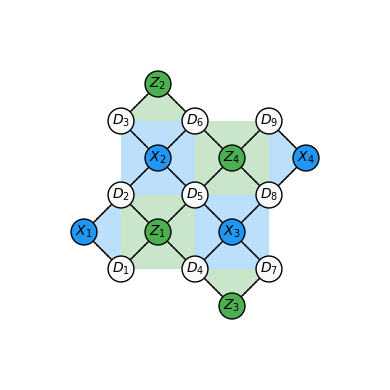

In [4]:
LAYOUT_FILE = "d3_rotated_layout.yaml"
layout = Layout.from_yaml(LAYOUT_DIR / LAYOUT_FILE)

fig, ax = plt.subplots(figsize=(4, 4))
plot_layout(layout, label_qubits=True, draw_patches=True, axis=ax)
plt.tight_layout()
plt.show()

In [5]:
proj_mat = layout.projection_matrix(stab_type="z_type")

In [6]:
DIR = EXP_DIR / "test"
directories = DIR.glob("*")
for circuit_dir in directories:
    print(circuit_dir.name)

surf-code_d3_bZ_s0_n10000_r10
surf-code_d3_bZ_s0_n10000_r11
surf-code_d3_bZ_s0_n10000_r12
surf-code_d3_bZ_s0_n10000_r13
surf-code_d3_bZ_s0_n10000_r14
surf-code_d3_bZ_s0_n10000_r15
surf-code_d3_bZ_s0_n10000_r16
surf-code_d3_bZ_s0_n10000_r17
surf-code_d3_bZ_s0_n10000_r18
surf-code_d3_bZ_s0_n10000_r19
surf-code_d3_bZ_s0_n10000_r20
surf-code_d3_bZ_s0_n10000_r21
surf-code_d3_bZ_s0_n10000_r22
surf-code_d3_bZ_s0_n10000_r23
surf-code_d3_bZ_s0_n10000_r24
surf-code_d3_bZ_s0_n10000_r25
surf-code_d3_bZ_s0_n10000_r26
surf-code_d3_bZ_s0_n10000_r27
surf-code_d3_bZ_s0_n10000_r28
surf-code_d3_bZ_s0_n10000_r29
surf-code_d3_bZ_s0_n10000_r3
surf-code_d3_bZ_s0_n10000_r30
surf-code_d3_bZ_s0_n10000_r31
surf-code_d3_bZ_s0_n10000_r32
surf-code_d3_bZ_s0_n10000_r33
surf-code_d3_bZ_s0_n10000_r34
surf-code_d3_bZ_s0_n10000_r35
surf-code_d3_bZ_s0_n10000_r36
surf-code_d3_bZ_s0_n10000_r37
surf-code_d3_bZ_s0_n10000_r38
surf-code_d3_bZ_s0_n10000_r39
surf-code_d3_bZ_s0_n10000_r4
surf-code_d3_bZ_s0_n10000_r40
surf-code_d3

# Load dataset and decode

In [7]:
ROUNDS_RANGE = range(3, 60)
LOG_STATES = [0, 1]


num_rounds = len(ROUNDS_RANGE)
num_states = len(LOG_STATES)
data = np.zeros((num_states, num_rounds))

for round_idx, num_rounds in enumerate(ROUNDS_RANGE):
    for state_idx, state in enumerate(LOG_STATES):
        circ_dir = f"surf-code_d3_bZ_s{state}_n10000_r{num_rounds}"
        print(circ_dir, end="\r")

        # load dataset
        test_dataset = xr.load_dataset(
            EXP_DIR / "test" / circ_dir / "measurements.nc"
        )
        defects, log_errors = preprocess_data(test_dataset, proj_mat)

        # generate decoder
        DETECTOR_ERROR_MODEL = EXP_DIR / "test" / circ_dir / "detector_error_model"
        if not DETECTOR_ERROR_MODEL.exists():
            raise ValueError(f"stim model does not exist in file: {DETECTOR_ERROR_MODEL}")

        detector_error_model = stim.DetectorErrorModel.from_file(DETECTOR_ERROR_MODEL)
        MWPM = pymatching.Matching.from_detector_error_model(detector_error_model)

        # decode
        prediction = np.array([MWPM.decode(i) for i in defects]).flatten()

        # analyse performance
        log_fid = logical_fidelity(prediction, log_errors)

        data[state_idx, round_idx] = log_fid
        
fid_arr = xr.DataArray(data, dims=["log_state", "qec_round"], coords=dict(log_state=LOG_STATES, qec_round=list(ROUNDS_RANGE)))

# Analysis metrics of decoding

In [8]:
log_fid = fid_arr.mean(dim="log_state")

In [9]:
model = LogicalFidelityDecay()
params = model.guess(log_fid.values, x=log_fid.qec_round.values)
out = model.fit(log_fid.values, params, x=log_fid.qec_round.values, min_qec=3)

Text(0, 0.5, 'logical fidelity')

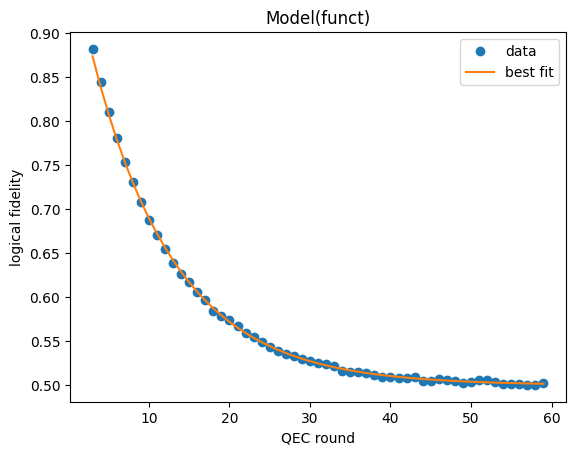

In [10]:
ax = out.plot_fit()
ax.set_xlabel("QEC round")
ax.set_ylabel("logical fidelity")

In [11]:
print("logical error rate per cycle =", lmfit_par_to_ufloat(out.params["error_rate"]))

logical error rate per cycle = 0.04615+/-0.00011
